In [1]:
# Common imports
import numpy as np
import os
import pandas as pd
import time

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


In [3]:
PREPROCESSED_X_PATH = './data/preprocessed_X.pkl'
PREPROCESSED_Y_PATH = './data/preprocessed_y.pkl'

In [4]:
from sklearn.utils import shuffle

X = np.load(PREPROCESSED_X_PATH)
y = np.load(PREPROCESSED_Y_PATH)

X, y = shuffle(X, y)

#Split into train, test and validation data
X_train = np.array(X[:int(len(X)*0.7)], dtype=np.float32)
y_train = np.array(y[:int(len(y)*0.7)], dtype=np.float32)

X_test = np.array(X[int(len(X)*0.9):], dtype=np.float32)
y_test = np.array(y[int(len(y)*0.9):], dtype=np.float32)

X_valid = np.array(X[int(len(X)*0.7):int(len(X)*0.9)], dtype=np.float32)
y_valid = np.array(y[int(len(y)*0.7):int(len(y)*0.9)], dtype=np.float32)

Initial shape:  (3214, 12, 80, 1)
Reshaped:  (3214, 960)


In [10]:
reset_graph()

#building a CNN using tensorflow
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
import tensorflow as tf
import numpy as np
import random

he_init = tf.contrib.layers.variance_scaling_initializer()

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None, 
                 height=12, width=80, channels=1, architecture=1, 
                 conv1={'conv1_fmaps':16, 'conv1_ksize':5, 'conv1_stride':1, 'conv1_dropout':None, 'conv1_activation':tf.nn.elu},
                 conv2={'conv2_fmaps':32, 'conv2_ksize':5, 'conv2_stride':1, 'conv2_dropout':0.2, 'conv2_activation':tf.nn.elu}):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self.height = height
        self.width = width
        self.channels = channels
        self.conv1_fmaps = conv1['conv1_fmaps']
        self.conv1_ksize = conv1['conv1_ksize']
        self.conv1_stride = conv1['conv1_stride']
        self.conv1_dropout = conv1['conv1_dropout']
        self.conv1_activation = conv1['conv1_activation']
        self.conv2_fmaps = conv2['conv2_fmaps']
        self.conv2_ksize = conv2['conv2_ksize']
        self.conv2_stride = conv2['conv2_stride']
        self.conv2_dropout = conv2['conv2_dropout']
        self.conv2_activation = conv2['conv2_activation']
        self.architecture = architecture
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _cnn(self, inputs):
        with tf.name_scope("conv1"):
            conv1_fmaps = self.conv1_fmaps #filters
            conv1_ksize = self.conv1_ksize
            conv1_stride = self.conv1_stride
            conv1_activation = self.conv1_activation
            conv1_pad = "SAME"
            conv1_dropout = self.conv1_dropout
            conv1 = tf.layers.conv2d(inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                     strides=conv1_stride, padding=conv1_pad,
                                     activation=conv1_activation, name="conv1")
            if conv1_dropout:
                conv1 = tf.layers.dropout(conv1, conv1_dropout, training=self._training)

        with tf.name_scope("pool1"):
            pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            
        with tf.name_scope("conv2"):
            conv2_fmaps = self.conv2_fmaps
            conv2_ksize = self.conv2_ksize
            conv2_stride = self.conv2_stride
            conv2_pad = "SAME"
            conv2_dropout = self.conv2_dropout
            conv2_activation = self.conv2_activation
            conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                     strides=conv2_stride, padding=conv2_pad,
                                     activation=conv2_activation, name="conv2")
            if conv2_dropout:
                conv2 = tf.layers.dropout(conv2, conv2_dropout, training=self._training)

        pool2_fmaps = conv2_fmaps
        pool2_flat_shape = int(((self.height/2)/2) * ((self.width/2)/2) * pool2_fmaps)
        with tf.name_scope("pool2"):
            pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            pool2_flat = tf.reshape(pool2, shape=[-1, pool2_flat_shape])
            

        return pool2_flat

    def _cnn2(self, inputs):
        with tf.name_scope("conv1"):
            conv1_fmaps = self.conv1_fmaps #filters
            conv1_ksize = self.conv1_ksize
            conv1_stride = self.conv1_stride
            conv1_activation = self.conv1_activation
            conv1_pad = "SAME"
            conv1_dropout = self.conv1_dropout
            conv1 = tf.layers.conv2d(inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                     strides=conv1_stride, padding=conv1_pad,
                                     activation=conv1_activation, name="conv1")
            

        with tf.name_scope("pool1"):
            pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            if conv1_dropout:
                pool1 = tf.layers.dropout(pool1, conv1_dropout, training=self._training)
            
        with tf.name_scope("conv2"):
            conv2_fmaps = self.conv2_fmaps
            conv2_ksize = self.conv2_ksize
            conv2_stride = self.conv2_stride
            conv2_pad = "SAME"
            conv2_dropout = self.conv2_dropout
            conv2_activation = self.conv2_activation
            conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                     strides=conv2_stride, padding=conv2_pad,
                                     activation=conv2_activation, name="conv2")

        pool2_fmaps = conv2_fmaps
        pool2_flat_shape = int(((self.height/2)/2) * ((self.width/2)/2) * pool2_fmaps)
        with tf.name_scope("pool2"):
            pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            pool2_flat = tf.reshape(pool2, shape=[-1, pool2_flat_shape])
            if conv2_dropout:
                pool2_flat = tf.layers.dropout(pool2_flat, conv2_dropout, training=self._training)
            

        return pool2_flat

    def _cnn3(self, inputs):
        with tf.name_scope("conv1"):
            conv1_fmaps = self.conv1_fmaps #filters
            conv1_ksize = self.conv1_ksize
            conv1_stride = self.conv1_stride
            conv1_activation = self.conv1_activation
            conv1_pad = "SAME"
            conv1_dropout = self.conv1_dropout
            conv1 = tf.layers.conv2d(inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                     strides=conv1_stride, padding=conv1_pad,
                                     activation=conv1_activation, name="conv1")
            if conv1_dropout:
                conv1 = tf.layers.dropout(conv1, conv1_dropout, training=self._training)
            
        with tf.name_scope("conv2"):
            conv2_fmaps = self.conv2_fmaps
            conv2_ksize = self.conv2_ksize
            conv2_stride = self.conv2_stride
            conv2_pad = "SAME"
            conv2_dropout = self.conv2_dropout
            conv2_activation = self.conv2_activation
            conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                     strides=conv2_stride, padding=conv2_pad,
                                     activation=conv2_activation, name="conv2")

        pool2_fmaps = conv2_fmaps
        pool2_flat_shape = int((self.height/2) * (self.width/2) * pool2_fmaps)
        with tf.name_scope("pool2"):
            pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            pool2_flat = tf.reshape(pool2, shape=[-1, pool2_flat_shape])
            if conv2_dropout:
                pool2_flat = tf.layers.dropout(pool2_flat, conv2_dropout, training=self._training)
            

        return pool2_flat

    def _cnn4(self, inputs):
        with tf.name_scope("conv1"):
            conv1_fmaps = self.conv1_fmaps #filters
            conv1_ksize = self.conv1_ksize
            conv1_stride = self.conv1_stride
            conv1_activation = self.conv1_activation
            conv1_pad = "SAME"
            conv1_dropout = self.conv1_dropout
            conv1 = tf.layers.conv2d(inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                     strides=conv1_stride, padding=conv1_pad,
                                     activation=conv1_activation, name="conv1")
            if conv1_dropout:
                conv1 = tf.layers.dropout(conv1, conv1_dropout, training=self._training)

        pool2_fmaps = conv1_fmaps
        pool2_flat_shape = int((self.height/2) * (self.width/2) * pool2_fmaps)
        with tf.name_scope("pool2"):
            pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            pool2_flat = tf.reshape(pool2, shape=[-1, pool2_flat_shape])
            

        return pool2_flat

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""

        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        X_reshaped = tf.reshape(X, shape=[-1, self.height, self.width, self.channels])
        y = tf.placeholder(tf.int32, shape=[None], name="y")
        self._training = tf.placeholder_with_default(False, shape=[], name='training')

        if self.architecture == 1: #conv1 -> Drop -> max_pool -> conv2 -> Drop -> Max_pool
            cnn_outputs = self._cnn(X_reshaped)
        if self.architecture == 2: #conv1 -> max_pool -> Drop -> conv2 -> max_pool -> Drop
            cnn_outputs = self._cnn2(X_reshaped)
        if self.architecture == 3: #conv1 -> Drop-> conv2 -> max_pool -> Drop
            cnn_outputs = self._cnn3(X_reshaped)
        if self.architecture == 4: #conv -> Drop -> max_pool
            cnn_outputs = self._cnn4(X_reshaped)

        with tf.name_scope("dnn"):
            dnn_outputs = self._dnn(cnn_outputs)

        with tf.name_scope("output"):
            logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="output")
            Y_proba = tf.nn.softmax(logits, name="Y_proba")

        with tf.name_scope("train"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
            loss = tf.reduce_mean(xentropy)
            optimizer = tf.train.AdamOptimizer()
            training_op = optimizer.minimize(loss)

        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

        with tf.name_scope("init_and_save"):
            init = tf.global_variables_initializer()
            saver = tf.train.Saver()

        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X_train, y_train, n_epochs=300, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = self.height * self.width * self.channels
        n_outputs = np.amax(y_train) + 1
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        self.loss_values = []
        self.acc_values = []
        self.best_loss_values = []


        batch_size = self.batch_size
        best_loss_val = np.infty
        check_interval = 50
        checks_since_last_progress = 0
        max_checks_without_progress = 30
        best_model_params = None 
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            if X_valid is not None and y_valid is not None:
                for epoch in range(n_epochs):
                    rnd_idx = np.random.permutation(len(X_train))
                    idx = 0
                    for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
                        X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices]
                        X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
                        sess.run(self._training_op, feed_dict={self._X: X_batch_reshaped, self._y: y_batch, self._training: True})
                        if idx % check_interval == 0:
                            X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
                            loss_val = self._loss.eval(feed_dict={self._X: X_valid_reshaped,
                                                            self._y: y_valid})
                            if loss_val < best_loss_val:
                                best_loss_val = loss_val
                                checks_since_last_progress = 0
                                best_model_params = self._get_model_params()
                            else:
                                checks_since_last_progress += 1
                            self.loss_values.append(loss_val)
                            self.best_loss_values.append(best_loss_val)
                        idx += 1
                    X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
                    acc_train = self._accuracy.eval(feed_dict={self._X: X_batch_reshaped, self._y: y_batch})
                    X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
                    acc_val = self._accuracy.eval(feed_dict={self._X: X_valid_reshaped,
                                                       self._y: y_valid})
                    self.acc_values.append(acc_val)
                    print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                              epoch, acc_train * 100, acc_val * 100, best_loss_val))
                    if checks_since_last_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break

                if best_model_params:
                    self._restore_model_params(best_model_params)
            else: 
                for epoch in range(n_epochs):
                    rnd_idx = np.random.permutation(len(X_train))
                    idx = 0
                    for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
                        X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices]
                        X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
                        sess.run(self._training_op, feed_dict={self._X: X_batch_reshaped, self._y: y_batch, self._training: True})

                    X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
                    acc_train = self._accuracy.eval(feed_dict={self._X: X_batch_reshaped, self._y: y_batch})
                    print("Epoch {}, train accuracy: {:.4f}%".format(
                              epoch, acc_train * 100))

            return self

    def predict(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            X_reshaped = np.reshape(X,(len(X), -1))
            return np.argmax(self._Y_proba.eval(feed_dict={self._X: X_reshaped}))

    def save(self, path):
        self._saver.save(self._session, path)

    def restore(self, path, n_inputs=960, n_outputs=48):
        self.close_session()

        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        self._session = tf.Session(graph=self._graph)
        
        self._saver.restore(self._session, path)

    def accuracy_score(self, X_test, y_test):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            X_test_reshaped = np.reshape(X_test,(len(X_test), -1))
            acc_test = self._accuracy.eval(feed_dict={self._X: X_test_reshaped, self._y: y_test})
            print("Final accuracy on test set:", acc_test)

            return acc_test

In [11]:
%%time

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

cnnClassifier = CNNClassifier(n_hidden_layers=2, n_neurons=400, optimizer_class=tf.train.AdamOptimizer,
                              learning_rate=0.01, batch_size=600, activation=leaky_relu(), dropout_rate=0.1,
                              conv1={'conv1_fmaps':16, 'conv1_ksize':5, 'conv1_stride':1, 'conv1_dropout':0.3, 'conv1_activation':tf.nn.relu},
                              conv2={'conv2_fmaps':16, 'conv2_ksize':5, 'conv2_stride':1, 'conv2_dropout':0.3, 'conv2_activation':tf.nn.relu},
                              architecture=1, height=12, width=80)
cnnClassifier.fit(X_train, y_train, n_epochs=300, X_valid=X_valid, y_valid=y_valid)

Epoch 0, train accuracy: 6.4085%, valid. accuracy: 6.6874%, valid. best loss: 3.841489
Epoch 1, train accuracy: 17.2230%, valid. accuracy: 17.7294%, valid. best loss: 3.741597
Epoch 2, train accuracy: 31.2417%, valid. accuracy: 28.4603%, valid. best loss: 3.515411
Epoch 3, train accuracy: 43.1242%, valid. accuracy: 37.0140%, valid. best loss: 3.171391
Epoch 4, train accuracy: 47.1295%, valid. accuracy: 40.4355%, valid. best loss: 2.776037
Epoch 5, train accuracy: 54.6061%, valid. accuracy: 49.1446%, valid. best loss: 2.459276
Epoch 6, train accuracy: 57.9439%, valid. accuracy: 54.2768%, valid. best loss: 2.194318
Epoch 7, train accuracy: 62.8838%, valid. accuracy: 55.8320%, valid. best loss: 1.946091
Epoch 8, train accuracy: 63.1509%, valid. accuracy: 57.2317%, valid. best loss: 1.797970
Epoch 9, train accuracy: 69.2924%, valid. accuracy: 63.7636%, valid. best loss: 1.627434
Epoch 10, train accuracy: 72.8972%, valid. accuracy: 65.3188%, valid. best loss: 1.463897
Epoch 11, train accura

Epoch 92, train accuracy: 99.7330%, valid. accuracy: 83.8258%, valid. best loss: 0.515005
Epoch 93, train accuracy: 99.8665%, valid. accuracy: 83.3593%, valid. best loss: 0.515005
Epoch 94, train accuracy: 99.5995%, valid. accuracy: 85.2255%, valid. best loss: 0.515005
Epoch 95, train accuracy: 99.1989%, valid. accuracy: 84.9145%, valid. best loss: 0.515005
Epoch 96, train accuracy: 99.7330%, valid. accuracy: 83.9813%, valid. best loss: 0.515005
Epoch 97, train accuracy: 100.0000%, valid. accuracy: 84.2924%, valid. best loss: 0.515005
Epoch 98, train accuracy: 99.5995%, valid. accuracy: 84.4479%, valid. best loss: 0.515005
Epoch 99, train accuracy: 99.7330%, valid. accuracy: 84.7589%, valid. best loss: 0.515005
Epoch 100, train accuracy: 99.8665%, valid. accuracy: 85.3810%, valid. best loss: 0.515005
Epoch 101, train accuracy: 99.7330%, valid. accuracy: 83.3593%, valid. best loss: 0.515005
Epoch 102, train accuracy: 99.7330%, valid. accuracy: 84.1369%, valid. best loss: 0.515005
Epoch 

In [13]:
cnnClassifier.accuracy_score(X_test, y_test)

Final accuracy on test set: 0.82298136


0.82298136

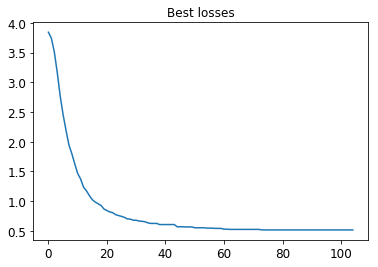

In [14]:
plt.plot(cnnClassifier.best_loss_values)
plt.title('Best losses')
plt.show()

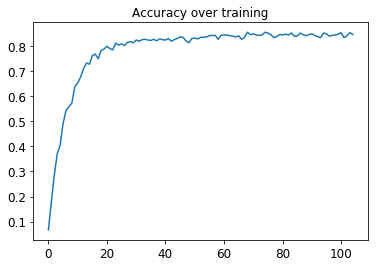

In [15]:
plt.plot(cnnClassifier.acc_values)
plt.title('Accuracy over training')
plt.show()